# A/B-тест интернет-магазина
**Цель проекта**: проанлизировать гипотезы по увеличению выручки.

**Задачи проекта**:
- Приоритизировать гипотезы отдела маркетинга по увеличению выручки;
- Исследовать накопительные метрики среднего чека и конверсии;
- Провести A/B-тест по данным с выбросами и без них;
- Определить, стоит ли продолжать тестирвоание.

Для реализации проекта будут использованы: данные Яндекс.Афиши с июня 2017 по конец мая 2018 года и инструменты Python.

**Этапы исследования**:
1. [Подготовка данных](#preanalysis)
2. [Приоритезация гипотез](#hypothesis)
3. [Анализ А/В-теста](#ab-analysis)
    - [Исследование стабильности кумулятивных метрик](#cummulative)
    - [Анализ выбросов](#quality)
    - [Изучение А/В-теста по "сырым" данным](#rawdata)  
    - [Изучение А/В-теста по "очищенным" данным](#cleardata)
4. [Вывод и рекомендации](#conclusion)

## [Подготовка данных](#preanalysis)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats

In [2]:
try:
    hypothesis = pd.read_csv('/content/hypothesis.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 150
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
try:
    orders = pd.read_csv('/content/orders.csv',  sep=',')
except:
    orders = pd.read_csv('/datasets/orders.csv',  sep=',')
orders.info()
orders.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [5]:
orders.isna().mean()

transactionId    0.0
visitorId        0.0
date             0.0
revenue          0.0
group            0.0
dtype: float64

In [6]:
orders.duplicated().mean()

0.0

In [7]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')
orders['date'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                    1197
unique                     31
top       2019-08-05 00:00:00
freq                       48
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

In [8]:
try:
    visitors = pd.read_csv('/content/visitors.csv', sep=',')
except:
    visitors = pd.read_csv('/datasets/visitors.csv',  sep=',')
visitors.info()
visitors.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [9]:
visitors.isna().mean()

date        0.0
group       0.0
visitors    0.0
dtype: float64

In [10]:
visitors.duplicated().mean()

0.0

In [11]:
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')
visitors['date'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                      62
unique                     31
top       2019-08-02 00:00:00
freq                        2
first     2019-08-01 00:00:00
last      2019-08-31 00:00:00
Name: date, dtype: object

Посмотрим на выборки анализируемых групп.

In [12]:
orders.groupby('group').agg({'visitorId' : 'nunique'})

,visitorId
group,
A,503
B,586


In [13]:
groupA = orders.query('group == "A"').reset_index()
groupB = orders.query('group == "B"').reset_index()
groupBvisitors = groupB['visitorId'].unique()

repetitiveAB = groupA.query('visitorId in @groupBvisitors')
repetitiveAB

,index,transactionId,visitorId,date,revenue,group
0,2,2961555356,4069496402,2019-08-15,400,A
9,26,2223239646,199603092,2019-08-15,3488,A
10,29,2220299125,3803269165,2019-08-15,700,A
11,33,486237576,2378935119,2019-08-15,1650,A
13,41,2594268419,237748145,2019-08-15,1090,A
...,...,...,...,...,...,...
542,1167,3757656646,4186807279,2019-08-14,4990,A
545,1173,3612788481,2712142231,2019-08-14,2490,A
547,1178,4052155355,2949041841,2019-08-14,190,A
550,1183,1458356232,963407295,2019-08-14,4940,A


В данных нет выбросов и пропущенных значений. Форматы данных приведены к корректному типу. Рассматриваемый период - весь август 2019.

В группе В пользователей, совершивших заказ, больше на 83. В группах есть пользователи с одинаковыми id, что возможно говорит о неверном сплитовании аудитории. Удалив данные, мы откажемся от 1/5 всех визитов, поэтому пока что оставим эти визиты. Возможно, они отфильтруются на этапе очистки данных.

## [Приоритизация гипотез](#hypothesis)

Для определения какие гипотезы лучше тестировать - проведем приоритизацию гипотез методами ICE и RICE. Первым рассмотрим анализ ICE, который оценивает такие параметры, как влияние, уверенность и простота.

In [14]:
hypothesis['ICE'] = (hypothesis['Impact']*hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis['ICE'] = hypothesis['ICE'].round(2)
hypothesis.sort_values(by='ICE', ascending=False)

,Hypothesis,Reach,Impact,Confidence,Efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


В рамках данного метода приоритетными гипотезами являются 8, 0 и 7. Посмотрим, как ситуация изменится в рамках оценки по методу RICE, который плюс к факторам, включенных в ICE, оценивает еще охват пользователей тестирования. 

In [15]:
hypothesis['RICE'] = (hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence']) / hypothesis['Efforts']
hypothesis['RICE'] = hypothesis['RICE'].round(2)
hypothesis_table = pd.DataFrame(hypothesis[['Hypothesis', 'RICE', 'ICE']]).sort_values(by=['RICE', 'ICE'], ascending=False)

cm = sns.light_palette("green", as_cmap=True)
hypothesis_table.style.background_gradient(cmap=cm)

,Hypothesis,RICE,ICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.000000,11.200000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.000000,7.000000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.000000,13.330000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.000000,8.000000
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.000000,1.120000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.000000,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.000000,1.330000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.000000,1.000000


Наиболее перспективными гипотезами по методу ICE, который оценивает такие параметры, как влияние, уверенность и простота, являются гипотезы:

* 8. Запустить акцию, дающую скидку на товар в день рождения;

* 0. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;

* 7. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;

* 6. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.

По методу RICE, который помимо описанных выше оценок учитывает еще охват пользователей:

* 7. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;

* 6. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;

* 2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;

* 0. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.*

Показатель Reach у 8 гипотезы, которая является приоритетной по методу ICE - ниже всего, что говорит о небольшом числе пользователей, которых охватит данное изменение. Гипотезы 7, 0 и 6 являются приоритетными по обоим фреймворкам. В рамках данного А/В-теста будет тестироваться гипотеза 7.

## [Анализ А/В-теста](#ab-analysis)
**[Исследование стабильности кумулятивных метрик](#cummulative)**

Для определения нужно ли продолжать тест, изучим накапливаемые метрики рассматриваемых данных.


In [16]:
#orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
#visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [17]:
datesGroups = orders[['date','group']].drop_duplicates()
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']) 

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


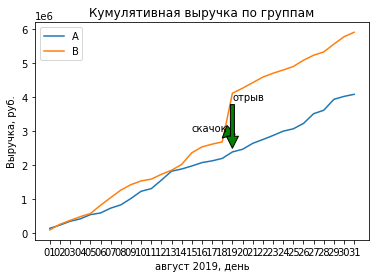

In [18]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

cumulativeRevenueA['day'] = cumulativeRevenueA['date'].astype('datetime64[D]')
cumulativeRevenueA['day'] = cumulativeRevenueA['day'].dt.strftime('%d')
cumulativeRevenueB['day'] = cumulativeRevenueB['date'].astype('datetime64[D]')
cumulativeRevenueB['day'] = cumulativeRevenueB['day'].dt.strftime('%d')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['day'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['day'], cumulativeRevenueB['revenue'], label='B')
plt.annotate('скачок', xy=('18', 2800000), xytext=('15', 3000000),arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('19', 2500000), xytext=('19', 3900000),arrowprops=dict(facecolor='g')) 
plt.legend() 
plt.rcParams["figure.figsize"] = (12,6)
plt.title('Кумулятивная выручка по группам')
plt.xlabel("август 2019, день")
plt.ylabel("Выручка, руб.")
plt.show() 

Выручка группы А стабильно ниже выручки группы В.

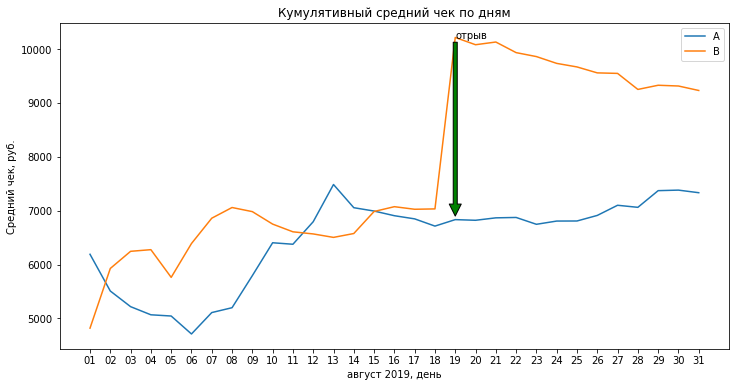

In [19]:
# графики кумулятивного среднего чека по дням

plt.plot(cumulativeRevenueA['day'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['day'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.rcParams["figure.figsize"] = (12,6)
plt.annotate('отрыв', xy=('19', 6900), xytext=('19', 10200),arrowprops=dict(facecolor='g'))
plt.title('Кумулятивный средний чек по дням')
plt.xlabel("август 2019, день")
plt.ylabel("Средний чек, руб.")
plt.show()


В целом средний чек группы А ниже среднего чека группы В. За рассматриваемый месяц только 1 и 13 августа средний чек группы В был выше, чем у группы А. 

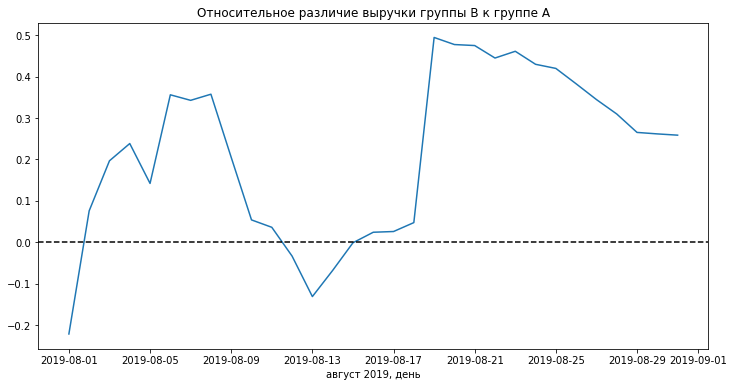

In [20]:
#относительное различие группы В к группе А

mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.rcParams["figure.figsize"] = (12,6)
plt.title('Относительное различие выручки группы В к группе А')
plt.xlabel("август 2019, день")
plt.show()


Группа А стабильно хуже группы В по показателю выручки, различие не имеет явной зависимости от времени.

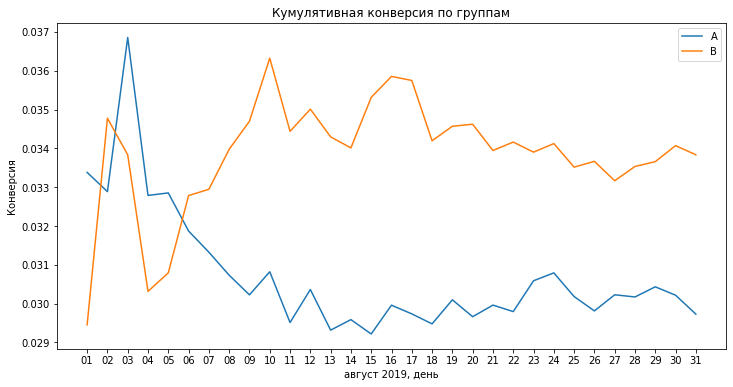

In [21]:
#график кумулятивной конверсии по группам

cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeData['day'] = cumulativeData['date'].astype('datetime64[D]')
cumulativeData['day'] = cumulativeData['day'].dt.strftime('%d')

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['day'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['day'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.rcParams["figure.figsize"] = (12,6)
plt.title('Кумулятивная конверсия по группам')
plt.xlabel("август 2019, день")
plt.ylabel("Конверсия")
plt.show()

Конверсия группы А в начале рассматриваемого периода была выше, чем у группы В, но уже с 3 дня исследования начала падать и после 6 августа имеет показаетли стабильно хуже, чем накопительные показатели группы В.

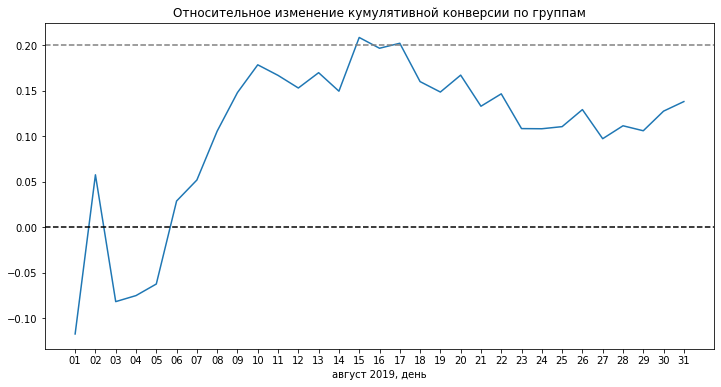

In [22]:
# относительного изменения кумулятивной конверсии по группам

mergedCumulativeConversions = cumulativeDataA[['day','conversion']].merge(cumulativeDataB[['day','conversion']], left_on='day', right_on='day', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['day'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.rcParams["figure.figsize"] = (12,6)
plt.title('Относительное изменение кумулятивной конверсии по группам')
plt.xlabel("август 2019, день")
plt.show()

Группа B стабильно лучше группы A по конверсии. Также по выручке и среднему чеку группа В превосходит группу А. Далее рассмотрим аномалии, которые возможно изменят данный вывод.

**[Анализ выбросов](#quality)**


In [23]:
ordersByVisitors = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByVisitors.columns = ['visitorId', 'orders']

print(ordersByVisitors.sort_values(by='orders', ascending=False).head(10)) 

       visitorId  orders
1023  4256040402      11
591   2458001652      11
569   2378935119       9
487   2038680547       8
44     199603092       5
744   3062433592       5
55     237748145       5
917   3803269165       5
299   1230306981       5
897   3717692402       5


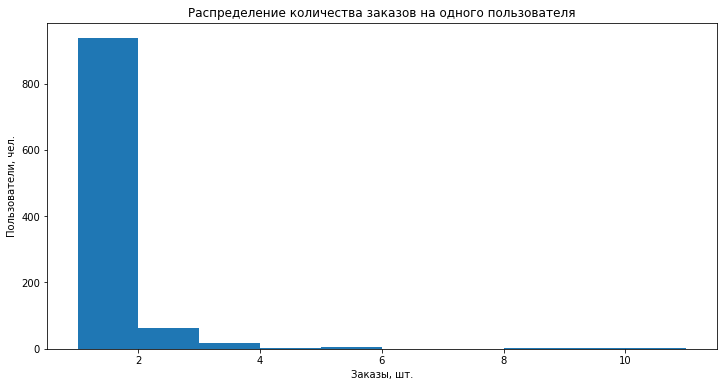

In [24]:
# Построим гистрограмму распределения количества заказов на одного пользователя.
plt.hist(ordersByVisitors['orders'])
plt.rcParams["figure.figsize"] = (12,6)
plt.title('Распределение количества заказов на одного пользователя')
plt.xlabel("Заказы, шт.")
plt.ylabel("Пользователи, чел.")
plt.show() 

#Большинство покупателей заказывали только один раз.

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-4 заказами тоже значительна. Помимо этого есть пользователи, совершившие 8-10 заказов, хотя их доля очень мала.

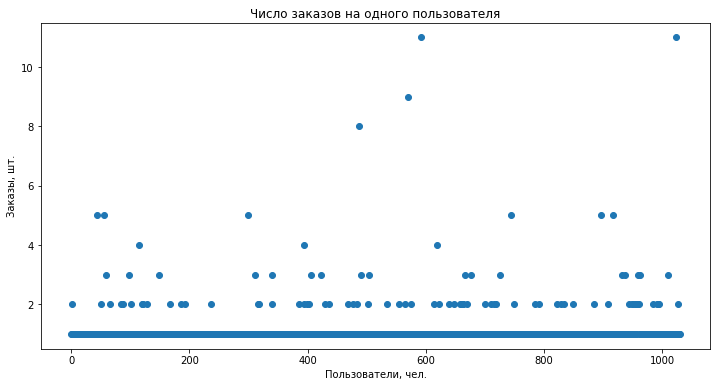

In [25]:
# Построим точечную диаграмму числа заказов на одного пользователя:
x_values = pd.Series(range(0,len(ordersByVisitors)))

plt.scatter(x_values, ordersByVisitors['orders']) 
plt.rcParams["figure.figsize"] = (12,6)
plt.title('Число заказов на одного пользователя')
plt.xlabel("Пользователи, чел.")
plt.ylabel("Заказы, шт.")
plt.show()

In [26]:
#95-й и 99-й перцентили количества заказов на пользователя

print(np.percentile(ordersByVisitors['orders'], [95, 99])) 

[2. 4.]


Как и было выявлено на первой гистограмме - большинство пользователей совершали не больше 2 заказов, а точнее: не более 5% пользователей оформляли больше чем 2 заказа и только 1% пользователей заказывали более 4 раз. Разумно выбрать 2 заказа на одного пользователя за нижнюю границу числа заказов, и отсеять аномальных пользователей по ней.

Далее проанализируем аномалии в стоимости заказов.

In [27]:
revenueByVisitors = (
    orders.drop(['group', 'transactionId', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'revenue': 'sum'})
)

revenueByVisitors.columns = ['visitorId', 'revenue']

mergeRevenueOrders = ordersByVisitors.merge(revenueByVisitors, on='visitorId')
mergeRevenueOrders['revenue_visitors'] = mergeRevenueOrders['revenue']/mergeRevenueOrders['orders']
mergeRevenueOrders['revenue_visitors'] = mergeRevenueOrders['revenue_visitors'].round(2)
mergeRevenueOrders.sort_values(by='revenue_visitors', ascending=False).head(10)

,visitorId,orders,revenue,revenue_visitors
463,1920142716,1,1294500,1294500.0
503,2108080724,1,202740,202740.0
314,1307669133,1,92550,92550.0
213,888512513,1,86620,86620.0
1026,4266935830,2,157980,78990.0
993,4133034833,1,67990,67990.0
279,1164614297,1,66350,66350.0
26,148427295,1,65710,65710.0
211,887908475,1,60450,60450.0
968,4003628586,1,58550,58550.0


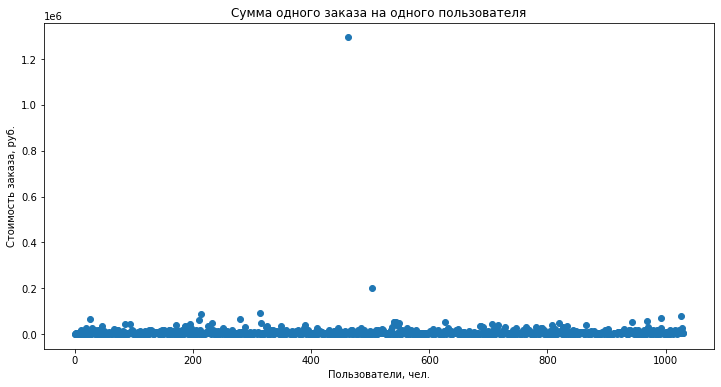

In [28]:
x_values = pd.Series(range(0,len(mergeRevenueOrders['revenue_visitors'])))

plt.scatter(x_values, mergeRevenueOrders['revenue_visitors'])
plt.rcParams["figure.figsize"] = (12,6)
plt.title('Сумма одного заказа на одного пользователя')
plt.xlabel("Пользователи, чел.")
plt.ylabel("Стоимость заказа, руб.")
plt.show()

In [29]:
print(np.percentile(mergeRevenueOrders['revenue_visitors'], [95, 99]))

[27625. 53904.]


В данных есть немного дорогих заказов. По графику видно, что в основном пользователи совершали заказы до 20000. Отсеим заказы с суммой больше 27625 как аномальные.

**[Изучение А/В-теста по "сырым" данным](#rawdata)** 

Проверим первую гипотезу: конверсии групп А и В различается.

- H0 - статистически значимых различий в конверсии между группами нет.
- Н1 - статистически значимые различия в конверсии между группами есть.

Для сопоставления двух средних генеральных совокупностей изучим статистическую значимость различий в конверсии, будем использовать *p-value* и U-критерий Манна-Уитни.

In [30]:
#статистическую значимость различий в конверсии между группами по «сырым» данным

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']


visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

In [31]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = ['date','ordersCummulativeB','revenueCummulativeB']

In [32]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [33]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders'] 

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0) 

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value:', "{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))
print('Относительное различие в конверсии между группами: ', "{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))

p-value: 0.01679
Относительное различие в конверсии между группами:  0.138


p-value меньше 0.05. Значит, можно говорить о том, что в конверсии между группами есть статистически значимые различия: относительный прирост конверсии группы В к конверсии группы А равен 13,8%.

Проверим вторую гипотезу: средние чеки групп А и В различается.

- H0 - статистически значимых различий в конверсии между группами нет.
- Н1 - статистически значимые различия в конверсии между группами есть.

In [34]:
print('p-value:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1]))
print('Относительное различие в среднем чеке между группами: ', '{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.729
Относительное различие в среднем чеке между группами:  0.259


p-value больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в средних чеках между группами нет, не отвергаем. Относительный проигрыш в среднем чеке группы А относительно группы В равен 25,9%.

**[Изучение А/В-теста по "очищенным" данным](#cleardata)**

Ранее была определена нижняя граница числа заказов - 2 заказа. Отсеим аномальные заказы именно по ней. Сумма среднего чека считается аномальной от 27625.

In [35]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)

usersWithExpensiveOrders = orders[orders['revenue'] > 27625]['visitorId']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape) 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: visitorId, dtype: int64
(75,)


В данных всего 75 аномальных пользователей. Посмотрим, как изменится результат А/В-теста без их учета. И проверим гипотезу о том, что конверсии групп А и В по очищенным данным различается.

In [36]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value:', '{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered,alternative = 'two-sided')[1]))
print('Относительное различие в конверсии между группами: ','{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value: 0.01418
Относительное различие в конверсии между группами:  0.171


Гипотеза о разнице в конверсии по очищенным данным имеет ту же тенденцию, но относительный прирост группы В к группе А равен 17,1% вместо 13,8% по "сырым" данным.

Проверим гипотезу о том, что средние чеки групп А и В по очищенным данным различается.

In [37]:
print('{0:.3f}'.format(stats.mannwhitneyu(
        orders[np.logical_and(orders['group'] == 'A',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
            orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'], alternative = 'two-sided'
        )[1])
    )

print("{0:.3f}".format(orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()
        / orders[np.logical_and(orders['group'] == 'A',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()
        - 1
    )
) 


0.701
-0.028


Гипотезу о разнице в среднем чеке по очищенным не отвергаем. Относительный проигрыш в среднем чеке группы B относительно группы А равен 2,8%. По сырым данным проигрыш был у группы А.

## [Вывод и рекомендации](#conclusion)

- Были выявлены приоритетные для анализа гипотезы, на основе чего выбрана гипотеза для анализа:
    * Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- В основном покупатели заказывают только один раз;
- Большинсвто заказов не превышают 20000руб.;
- Аудитория группы В больше группы А;
- Имеется статистически значимое различие по конверсии между группами по «сырым» данным и по данным после фильтрации аномалий;
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A;
- График различия среднего чека между группами колеблется, по «сырым» данным результаты группы В лучше группы А, по «очищенным» - наоборот.

Тест необходимо продолжить для получения стабильной информации о среднем чеке.